# Melanoma Detection

## Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Import Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
!unzip -q /content/gdrive/MyDrive/CNN_assignment.zip

In [6]:
!ls 'Skin cancer ISIC The International Skin Imaging Collaboration'

Test  Train


In [8]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
train_dir = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
test_dir = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")


In [10]:
image_count_train = len(list(train_dir.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_dir.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Create Dataset

In [11]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123

Using 80% of the images for training, and 20% for validation.

In [12]:
train_img_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size= batch_size,
    image_size= (img_height, img_width),
    seed=seed,
    subset="training",
    validation_split=0.2)

test_img_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size= batch_size,
    image_size= (img_height, img_width),
    seed= seed)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 118 files belonging to 9 classes.


In [13]:
val_img_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size= batch_size,
    image_size= (img_height, img_width),
    seed= seed,
    subset="validation",
    validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
class_names = train_img_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data Visualization

In [15]:
import matplotlib.pyplot as plt

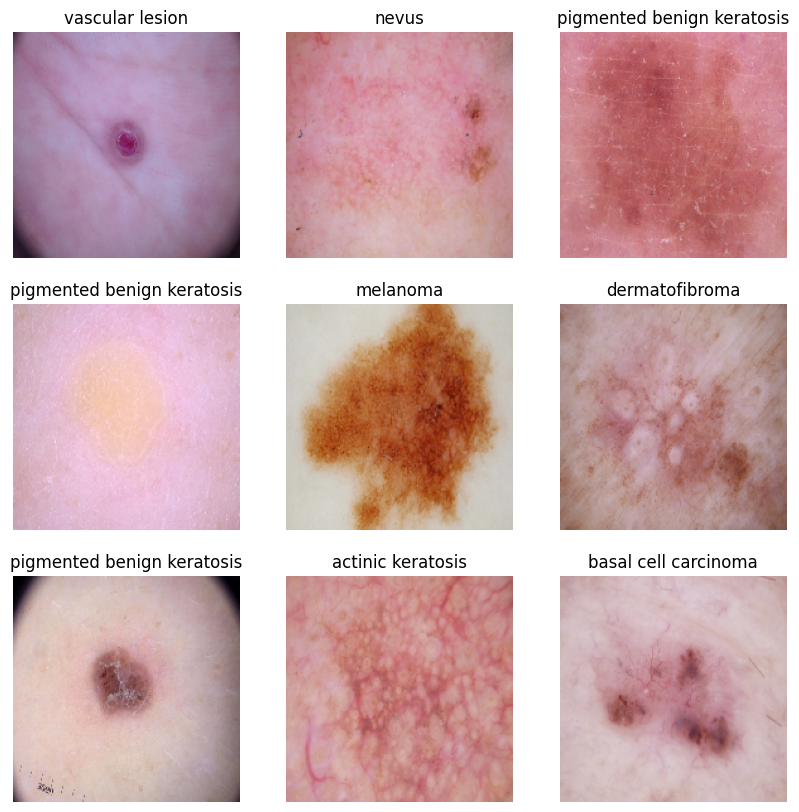

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_img_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_img_ds = train_img_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_img_ds = val_img_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [18]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

In [19]:
model.compile(optimizer="Adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 8)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 16)        2320      
                                                        

## Train the model

In [21]:
epochs = 20
history = model.fit(
  train_img_ds,
  validation_data=val_img_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 29s 81ms/step - loss: 2.0480 - accuracy: 0.2188 - val_loss: 1.9433 - val_accuracy: 0.2729
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.8807 - accuracy: 0.2930 - val_loss: 1.7383 - val_accuracy: 0.3803
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6953 - accuracy: 0.3867 - val_loss: 1.6403 - val_accuracy: 0.4183
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6225 - accuracy: 0.4012 - val_loss: 1.6354 - val_accuracy: 0.4049
Epoch 5/20
56/56 [==============================] - 2s 28ms/step - loss: 1.5936 - accuracy: 0.4129 - val_loss: 1.6298 - val_accuracy: 0.3982
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5599 - accuracy: 0.4353 - val_loss: 1.5576 - val_accuracy: 0.4407
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5523 - accuracy: 0.4431 - val_loss: 1.6634 - val_accuracy: 0.3848
Epoch 8/20
5

## Visualizing Training Data

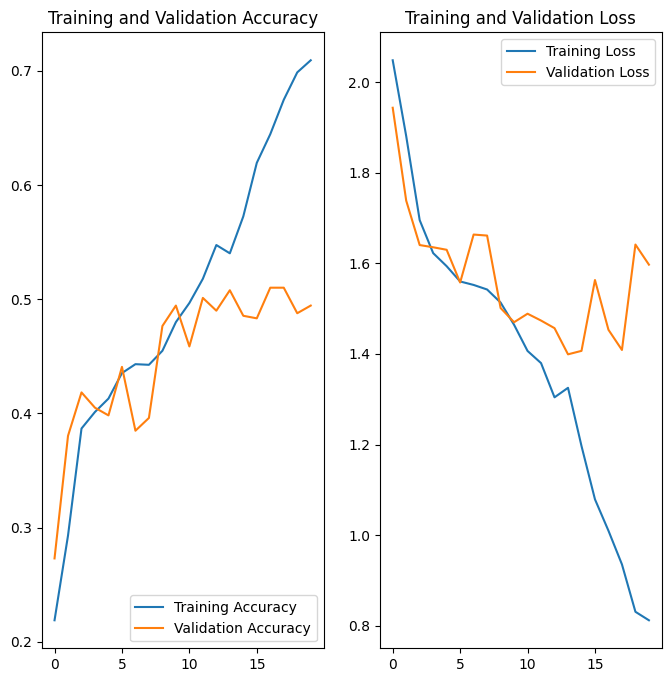

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The `model is overfitting` as can been seen by the training accuracy score of `70%` and a validation accuracy score of `47%`.

The graph shows, that the validation accuracy graph becomes consistent at 0.5 percent, while the training accuracy graph goes up linearly.


While the validation loss show a higher loss percentage than the training loss.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

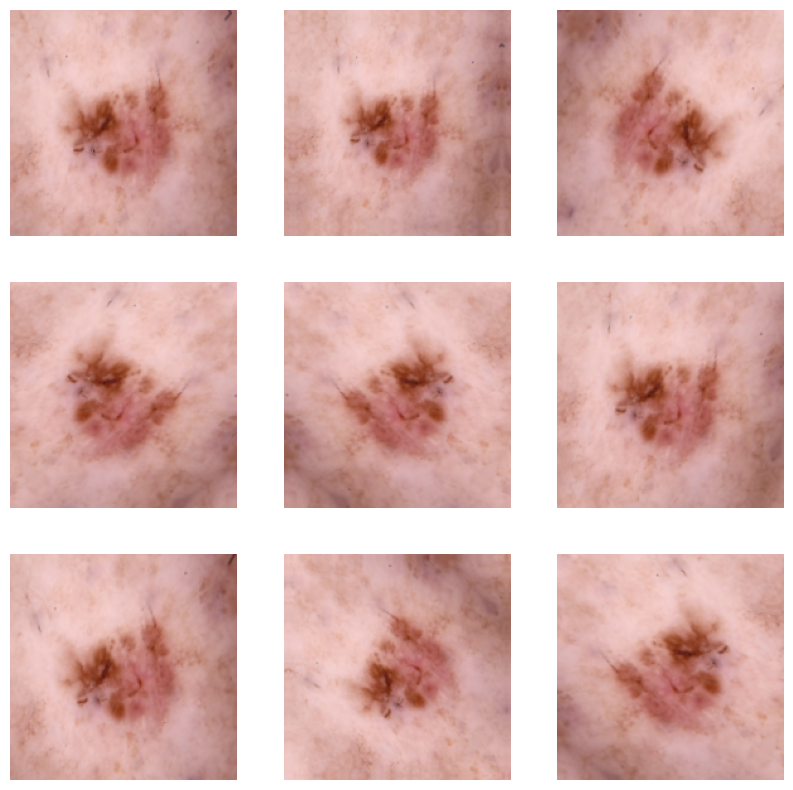

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_img_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Create the augmented model, compile and train the model

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training Model

In [27]:
epochs = 20
history = model.fit(
  train_img_ds,
  validation_data=val_img_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 35ms/step - loss: 2.0446 - accuracy: 0.2065 - val_loss: 2.0262 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.9030 - accuracy: 0.2751 - val_loss: 1.7916 - val_accuracy: 0.3400
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6658 - accuracy: 0.3772 - val_loss: 1.5752 - val_accuracy: 0.4228
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.6182 - accuracy: 0.4113 - val_loss: 1.5878 - val_accuracy: 0.4004
Epoch 5/20
56/56 [==============================] - 2s 33ms/step - loss: 1.6394 - accuracy: 0.3929 - val_loss: 1.6738 - val_accuracy: 0.4094
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5982 - accuracy: 0.4079 - val_loss: 1.5667 - val_accuracy: 0.4318
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5874 - accuracy: 0.4174 - val_loss: 1.5836 - val_accuracy: 0.4430
Epoch 8/20
56

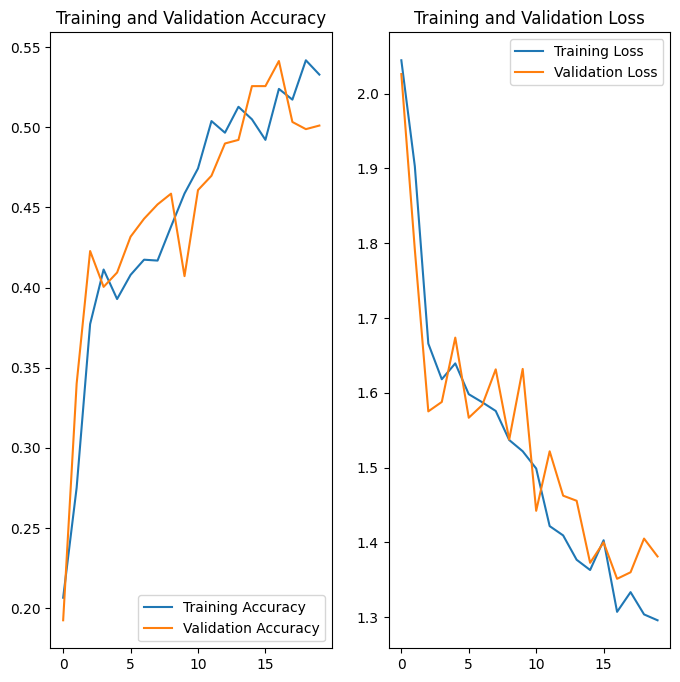

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

It is evident form the graph that the training and validation accuracy is converging.

The training and validation loss graph too is converging together and there is less gap between them.

It can be concluded the the overfitting problem has reduced significantly.

## Handel Class Imbalance

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [29]:
from glob import glob

path_list = [x for x in glob(os.path.join(train_dir, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(train_dir, '*', '*.jpg'))]
len(path_list)

2239

In [30]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
2235,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
2236,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
2237,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma


Class=0, n=114 (5.092%)
Class=2, n=95 (4.243%)
Class=6, n=77 (3.439%)
Class=8, n=139 (6.208%)
Class=4, n=357 (15.945%)
Class=3, n=438 (19.562%)
Class=5, n=462 (20.634%)
Class=7, n=181 (8.084%)
Class=1, n=376 (16.793%)


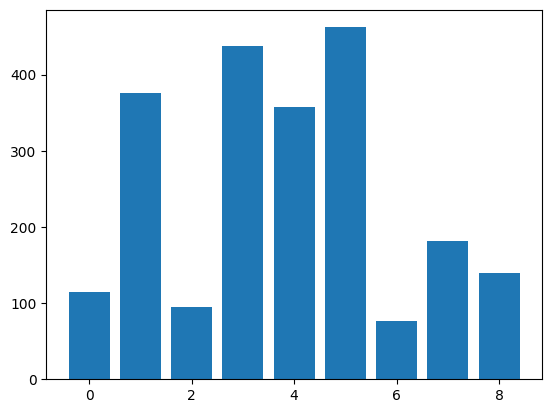

In [31]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

### The class imbalance problem show the following insight.

- The class with least number of samples are
  - Actinic Keratosis
  - Dermatofibroma
  - Seborrheic Keratosis
  - Squamous Cell Carcinoma
  - Vascular Lesion
- The classes that dominate the data in terms proportionate number of samples are:
  - Actinic Keratosis
  - Melanoma
  - Nevus
  - Pigmented Benign Keratosis

##  Rectify the class imbalance

In [32]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

- Instantiate a Pipeline object pointing to a directory containing your initial image data set.
- Define a number of operations to perform on this data set using your Pipeline object.
- Execute these operations by calling the Pipeline’s sample() method.

In [33]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9BB471FEE0>: 100%|██████████| 500/500 [00:16<00:00, 29.90 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9BBA107E20>: 100%|██████████| 500/500 [00:16<00:00, 31.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9C40B556F0>: 100%|██████████| 500/500 [00:17<00:00, 28.72 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D9BCBEFAEC0>: 100%|██████████| 500/500 [01:30<00:00,  5.52 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9C400C8610>: 100%|██████████| 500/500 [01:15<00:00,  6.64 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9BB47C3EE0>: 100%|██████████| 500/500 [00:15<00:00, 32.71 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D9BBA1B72E0>: 100%|██████████| 500/500 [00:45<00:00, 10.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9BB47A44F0>: 100%|██████████| 500/500 [00:15<00:00, 32.53 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9C40B56C80>: 100%|██████████| 500/500 [00:15<00:00, 33.09 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(train_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


## Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
path_list_new = [x for x in glob(os.path.join(train_dir, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_00f1249d-c42e-46ab-a003-f62131b57ff6.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_8d10899d-ae06-4d5a-9b18-944d5b0d1846.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_99142bdf-0544-461e-827a-fcdf8bab106b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026709.jpg_8bc0b77c-604c-473d-9de1-ab215ea0bf48.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025825.jpg_41227c4c-91d0-4946-9a5c-3a58d1cf97e9.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ou

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_dir, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [37]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-38-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [39]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

## training the model using Augmenter

In [40]:
batch_size = 32
img_height = 180
img_width = 180

## Creating Training Dataset

In [41]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


## Creating Validation Dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Create Model

In [54]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile Model

In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train Model

In [57]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 12s 40ms/step - loss: 1.8201 - accuracy: 0.2873 - val_loss: 2.2498 - val_accuracy: 0.1507
Epoch 2/30
169/169 [==============================] - 6s 37ms/step - loss: 1.6683 - accuracy: 0.3496 - val_loss: 2.2453 - val_accuracy: 0.1514
Epoch 3/30
169/169 [==============================] - 7s 39ms/step - loss: 1.5595 - accuracy: 0.4037 - val_loss: 2.0951 - val_accuracy: 0.2205
Epoch 4/30
169/169 [==============================] - 6s 38ms/step - loss: 1.4150 - accuracy: 0.4720 - val_loss: 2.2258 - val_accuracy: 0.2012
Epoch 5/30
169/169 [==============================] - 7s 42ms/step - loss: 1.1885 - accuracy: 0.5599 - val_loss: 1.3277 - val_accuracy: 0.5056
Epoch 6/30
169/169 [==============================] - 6s 38ms/step - loss: 0.9324 - accuracy: 0.6545 - val_loss: 1.6123 - val_accuracy: 0.4150
Epoch 7/30
169/169 [==============================] - 7s 41ms/step - loss: 0.7168 - accuracy: 0.7391 - val_loss: 1.3720 - val_accuracy: 0.556

## Visualize Model

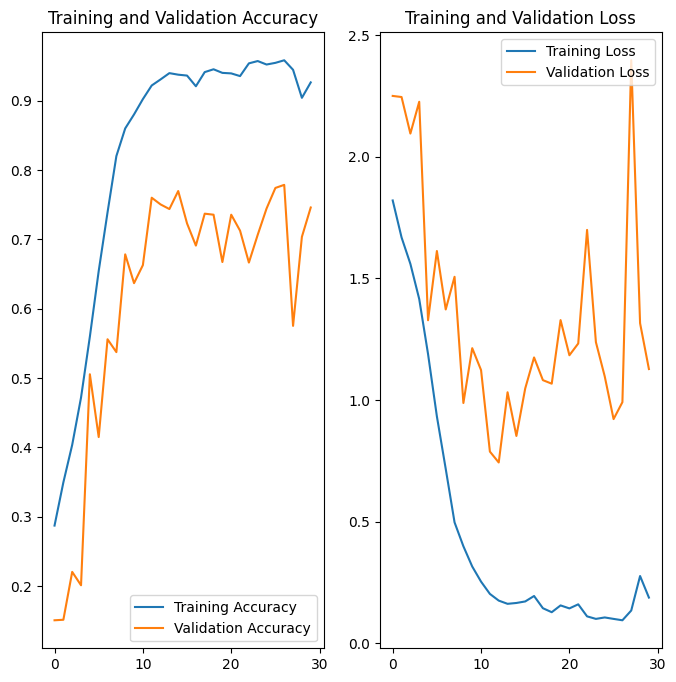

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

It is noticible that class re-balance did not improve the overfitting problem.

There is significant gap between the training and validation accuracy. The training accuracy rises linearly, while the validation accuracy becomes stangant at 70%.

Similar behaviour can be seen in the training and validation loss scores. There is a significant gap between training and validation loss. The training loss is decreasing linearly, while the validation loss shows a sudden upward spike after decreasing.